## Setup

In [1]:
import logging
import sys

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [2]:
# Resolve path when used in a usecase project
from pathlib import Path

sys.path.insert(0, str(Path("../../").resolve()))

In [3]:
import warnings


warnings.filterwarnings("ignore")

In [4]:
from modeling.datasets import get_sample_model_input_data, get_trained_model


df = get_sample_model_input_data()
sklearn_pipeline = get_trained_model()
current_feature_values = df.iloc[-1].to_dict()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Alternativelly, you can use one of our model classes and wrap your estimator/pipeline i.e.:

```python
from modeling import SklearnPipeline


sklearn_pipeline = SklearnPipeline(
    estimator=...,
    features_in=[...],
    features_out=[...],
    target=...,
)
```

## What is sensitivity analyser?

![anomation](_images/_sensitivity_analyzer.gif "segment")

**What is it?**

Interactive application that visualizes joint dependencies between model features and modeling target.

Manipulate model features values through interactive sliders to see instant updates in sensitivity plots representing dependency between model features and modeling target

**Why is it important?**


* Helps to build the client’s adoption of the models by visualizing model behavior for various input conditions and scenarios.

* Allows DS to understand learned dependencies for further model improvements

## `get_sensitivity_analyzer_app`

This function returns instance of Sensitivity Analyzer Dash application:

There are three types of features that are relevant for Sensitivity Analyzer:
1. `features_to_plot` – features that are shown on the sensitivity plots;
2. `features_to_manipulate` – features that are manipulable through model interactive model sliders;
3. `static_feature_values` – feature values required for making a prediction with model, in case they are not included in either `features_to_plot` or `features_to_manipulate`;

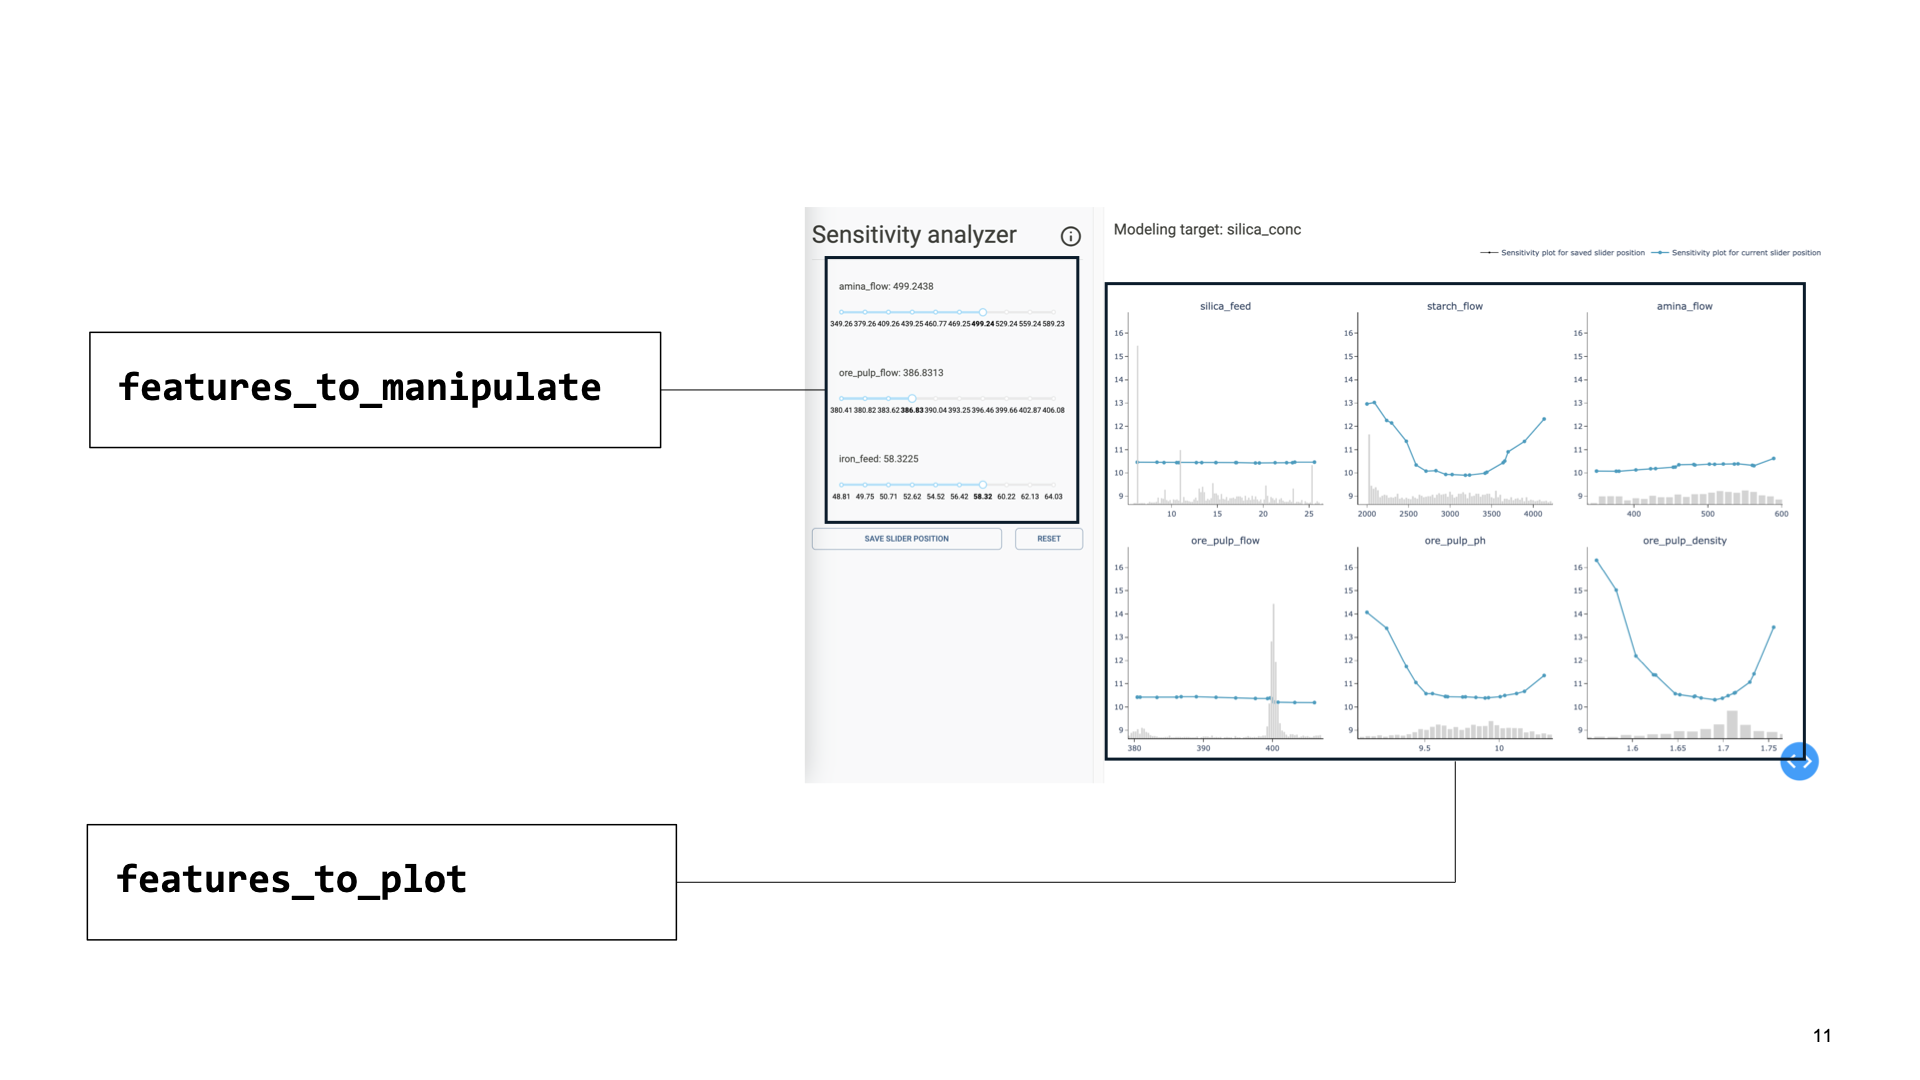

In [5]:
from modeling.sensitivity_analyser.app import get_sensitivity_analyzer_app


app = get_sensitivity_analyzer_app(
    features_to_plot=[
        'silica_feed',
        'starch_flow',
        'amina_flow',
        'ore_pulp_flow',
        'ore_pulp_ph',
        'ore_pulp_density',
    ],
    features_to_manipulate=[
        "amina_flow",
        'ore_pulp_flow',
        'iron_feed',
    ],
    model=sklearn_pipeline,
    data=df,
    static_feature_values=current_feature_values,
    initial_slider_values=current_feature_values,
    layout_config={
        "show_histogram": True,
        "share_y_axis": True,
        "save_slider_position": True,
    },
)

Calling `.run_server()` will run the application through your localhost:

In [6]:
app.run_server()

Dash app running on http://127.0.0.1:8050/


Below is the layout of the application running on the sample data:

You're able to change the input conditions through the interactive sliders and those changes will be instantly reflected in the sensitivity charts on the right part of the layout;

* **"Save slider position"** button allows you to save current slider position for comparison with other sliders positions. Saved position is marked as bold on the charts and the sensitivity plot related to saved position of the slider is drawn with black.

* **"Reset"** button resets the saved slider position to initial saved position

### `features_to_plot` parameter

`features_to_plot` parameter allows you to specify model features that are used for sensitivity charts generation on the right side of the layout;

There are several options, how `features_to_plot` can be specified using:

**1) a list of features**:
```python
    features_to_plot=[
        'iron_feed',
        'ore_pulp_ph',
    ],
```
In that case you don't provide any grid to be utilized, such that grid will be calculated automatically using 1) grid calculation config `features_to_plot_grid_config`, 2) historical data provided through `data` argument.

**2) a dict from features to plot to grid:**
```python
    features_to_plot={
        'iron_feed': None,
        'ore_pulp_ph': [
            9.1,
            9.466666666666667,
            9.833333333333334,
            10.2,
            10.566666666666666,
            10.75,
        ],
    },
```
In that case `features_to_plot` mapping `None` will receive grid calculated automatically just like in the example above; otherwise provided will be used

### `features_to_manipulate` parameter

`features_to_manipulate` parameter allows you to specify model features that are controlled through the sliders on the sidebar on the left side of the layout;

There are similar options, how grid can to be specified for `features_to_manipulate`, same as `features_to_plot`.

**1) a list of features:**
```python
    features_to_manipulate=[
        'silica_feed',
        'ore_pulp_flow',
    ],
```
In that case you don't provide any grid to be utilized, such that grid will be calculated automatically using 1) grid calculation config `features_to_manipulate_grid_config`, 2) historical data provided through `data` argument.

**2) a dict from features to plot to grid:**
```python
    features_to_manipulate={
        'silica_feed': None,
        'ore_pulp_flow': [
            380,
            390,
            400,
        ],
    },
```
In that case `features_to_manipulate` mapping `None` will receive grid calculated automatically just like in the example above; otherwise provided grid will be used

### `static_feature_values`

In order to make a prediction, model requires a specific set of features. `features_to_plot` and `features_to_manipulate` collect feature names and grid of values to utilized, however they might not cover all the model features set required for making a prediction; In case you will be asked to provide a dict mapping feature names into values, that will be used for making a prediction.

<div class="alert alert-info">
<b>Note</b>
    
Most of the time you will be using Sensitivity analyzer while investigating specific plant state.
    
A `pd.Series.to_dict()` method helps you to export plant state into dict format required by Sensitivity analyzer.
</div>

### `model`

Provide model instance for making the predictions. You are expected to provide `ModelBase` instance, which is a models standard in OptimusAI. Learn more about `ModelBase` from the [tutorial notebook](./model_base.ipynb).

### `data`

You'll be asked to provide some historical data in the format of `pd.DataFrame` in case
1. You have parameters in `features_to_plot` or `features_to_manipulate` without explicitly grid specified

OR

2. You have histogram layout enabled (which is the default behaviour)

### Grid configurations config

We calculate grid for both `features_to_plot` and `features_to_manipulate` parameters in case grid is not provided explicitly by user. We allow users to specify grid calculation strategies through the `features_to_plot_grid_config` and `features_to_manipulate_grid_config` input config parameters.

They both have the same structure that is defined by `modeling.sensitivity_analyser.configs.GridCalculationConfig` dataclass. Configurable parameters of the grid:

* `points_count`: number of points in the automatically composed grid
* `start_point_quantile`: quantile out from the `data` argument to be used as the **first points** in the automatically composed grid
* `end_point_quantile`: quantile out from the `data` argument to be used as the **last points** in the automatically composed grid
* `calculation_strategy`: can be either `"quantiles"`, `"uniform"` or `"quantiles+uniform"`. Defines the grid calculation strategy used to interval.

Grid configuration example:
```python
    features_to_plot_grid_config={
        "points_count": 10,
        "start_point_quantile": 0.01,
        "end_point_quantile": 0.99,
        "calculation_strategy": "quantiles+uniform",
    }
```

### `initial_slider_values`

Mapping `features_to_manipulate` model features into initial saved slider positions. This parameter is optional and first points in each grid are used by default in case `initial_slider_values` is not specified.

Note, that points specified with `initial_slider_values` are going to be added to slider grid.

<div class="alert alert-info">
<b>Note</b>

Most of the time you will be using Sensitivity analyzer while investigationg spesific plant state. You can set up initial saved slider positions out from data:
    
A `pd.Series.to_dict()` method helps you to export plant state into dict format required by Sensitivity analyzer.
</div>

### Layout configuration config

We provide several options for application layout configuration. Set those through `layout_config` input parameter

#### How to disable histogram layout on the background of charts?

Histogram calculation on the charts background is enabled by default; You can disable those updating `layout_config` input parameter in the following way:
```python
layout_config={
    "show_histogram": False,
},
```

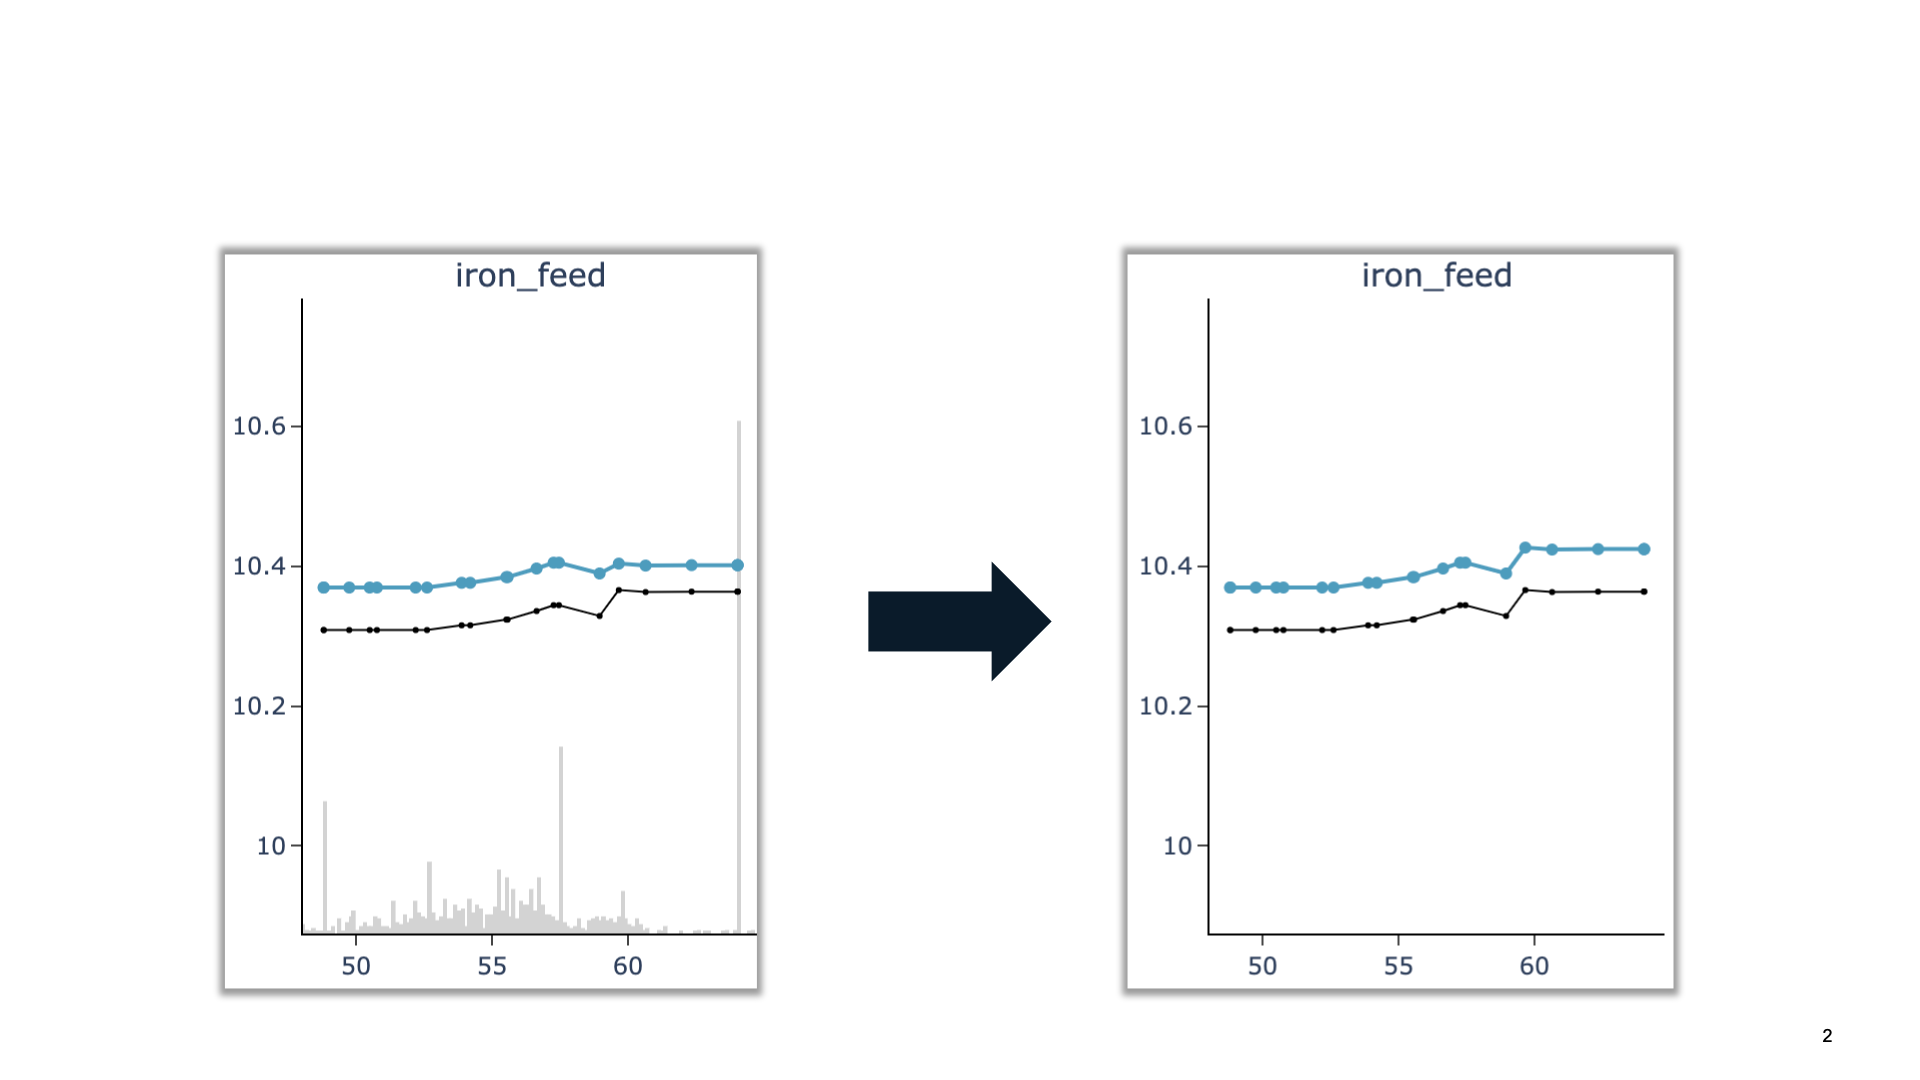

#### How to disable legend for the sensitivity plots?

Legend for sensitivity charts is enabled by default; You can disable it setting `layout_config` input parameter in the following way:
```python
layout_config={
    "show_legend": False,
},

```

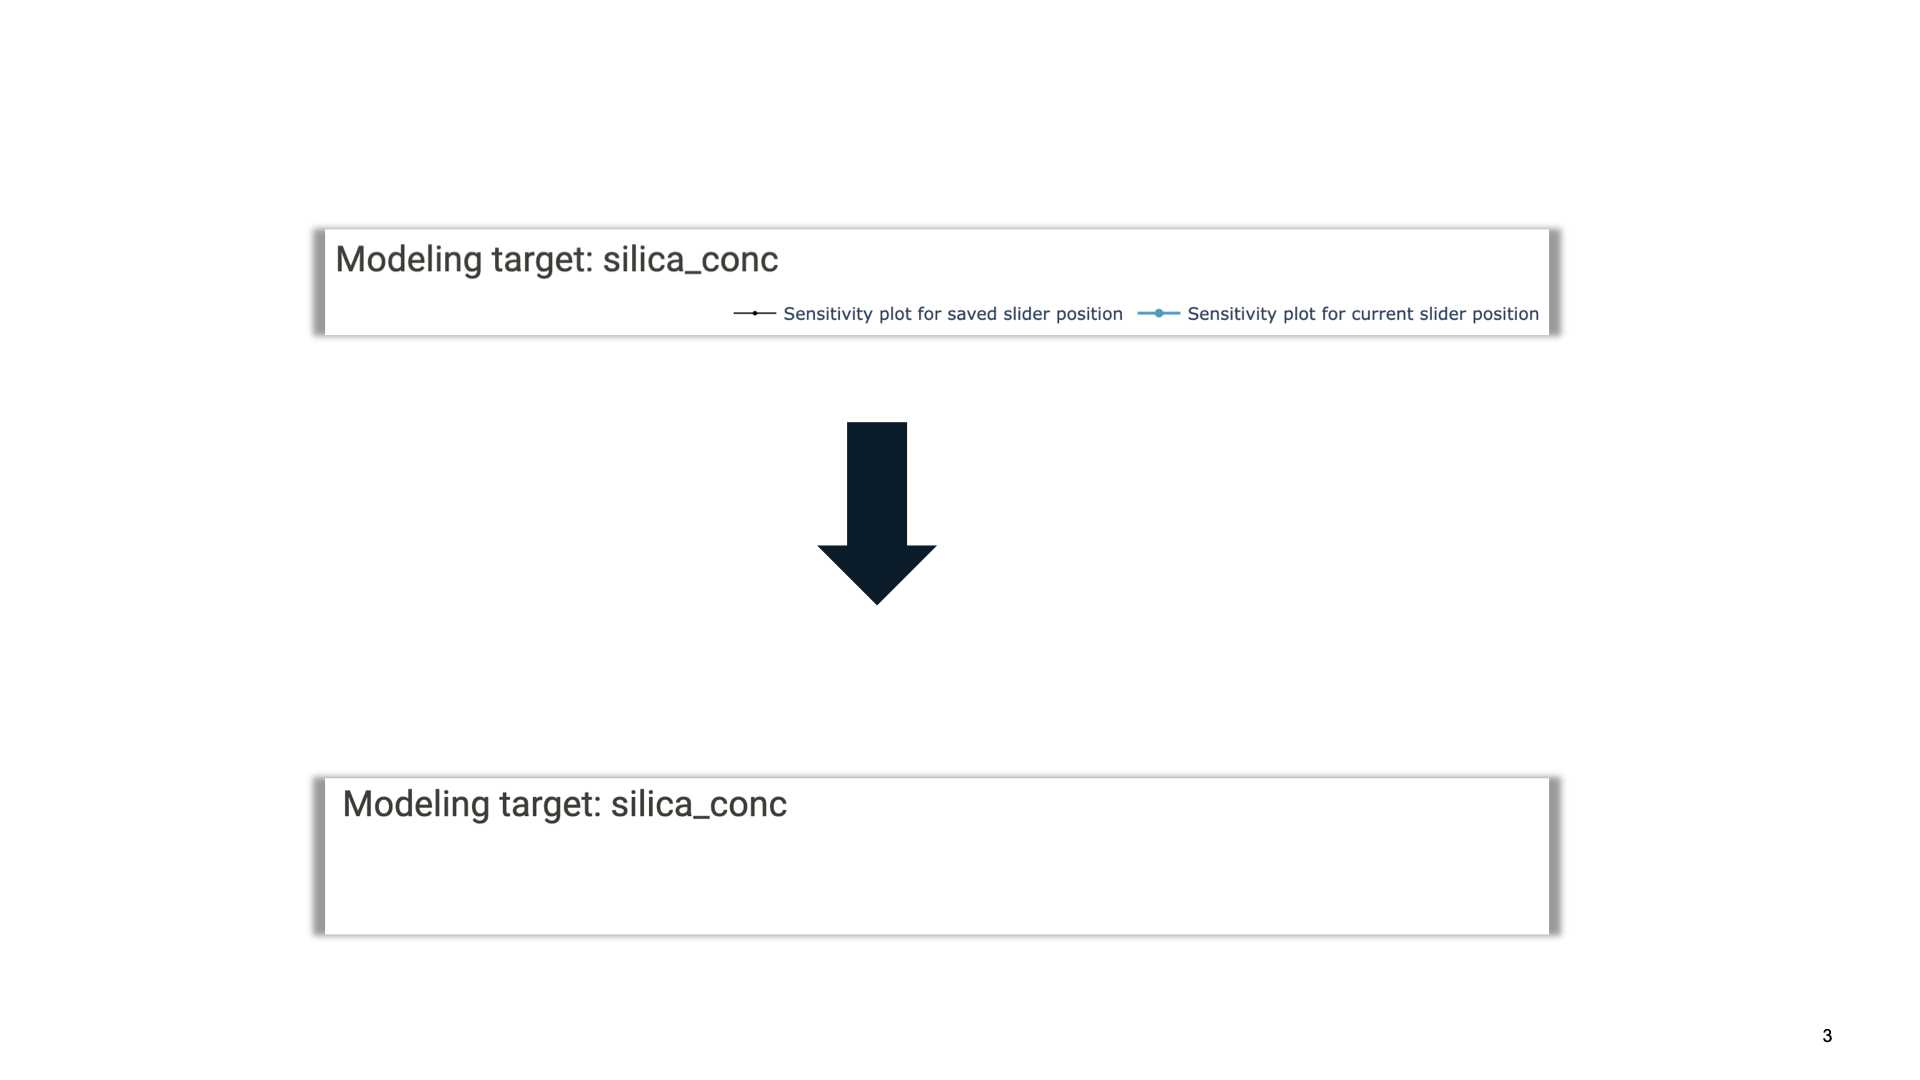

#### How to stop sharing Y-axis across the plots in the row?

Y-axis is shared between subplots by default; You can disable this by providing:

```python
layout_config={
    "share_y_axis": False,
},

```

#### How to change number of plots that are shown in one row?

Default number of subplots in one row is configurable setting as well; While default number if 3, you can choose any positive integer number; In the example below we'll switch to a single plot subplot in the row:

```python
layout_config={
    "max_plots_in_row": 1,
},

```

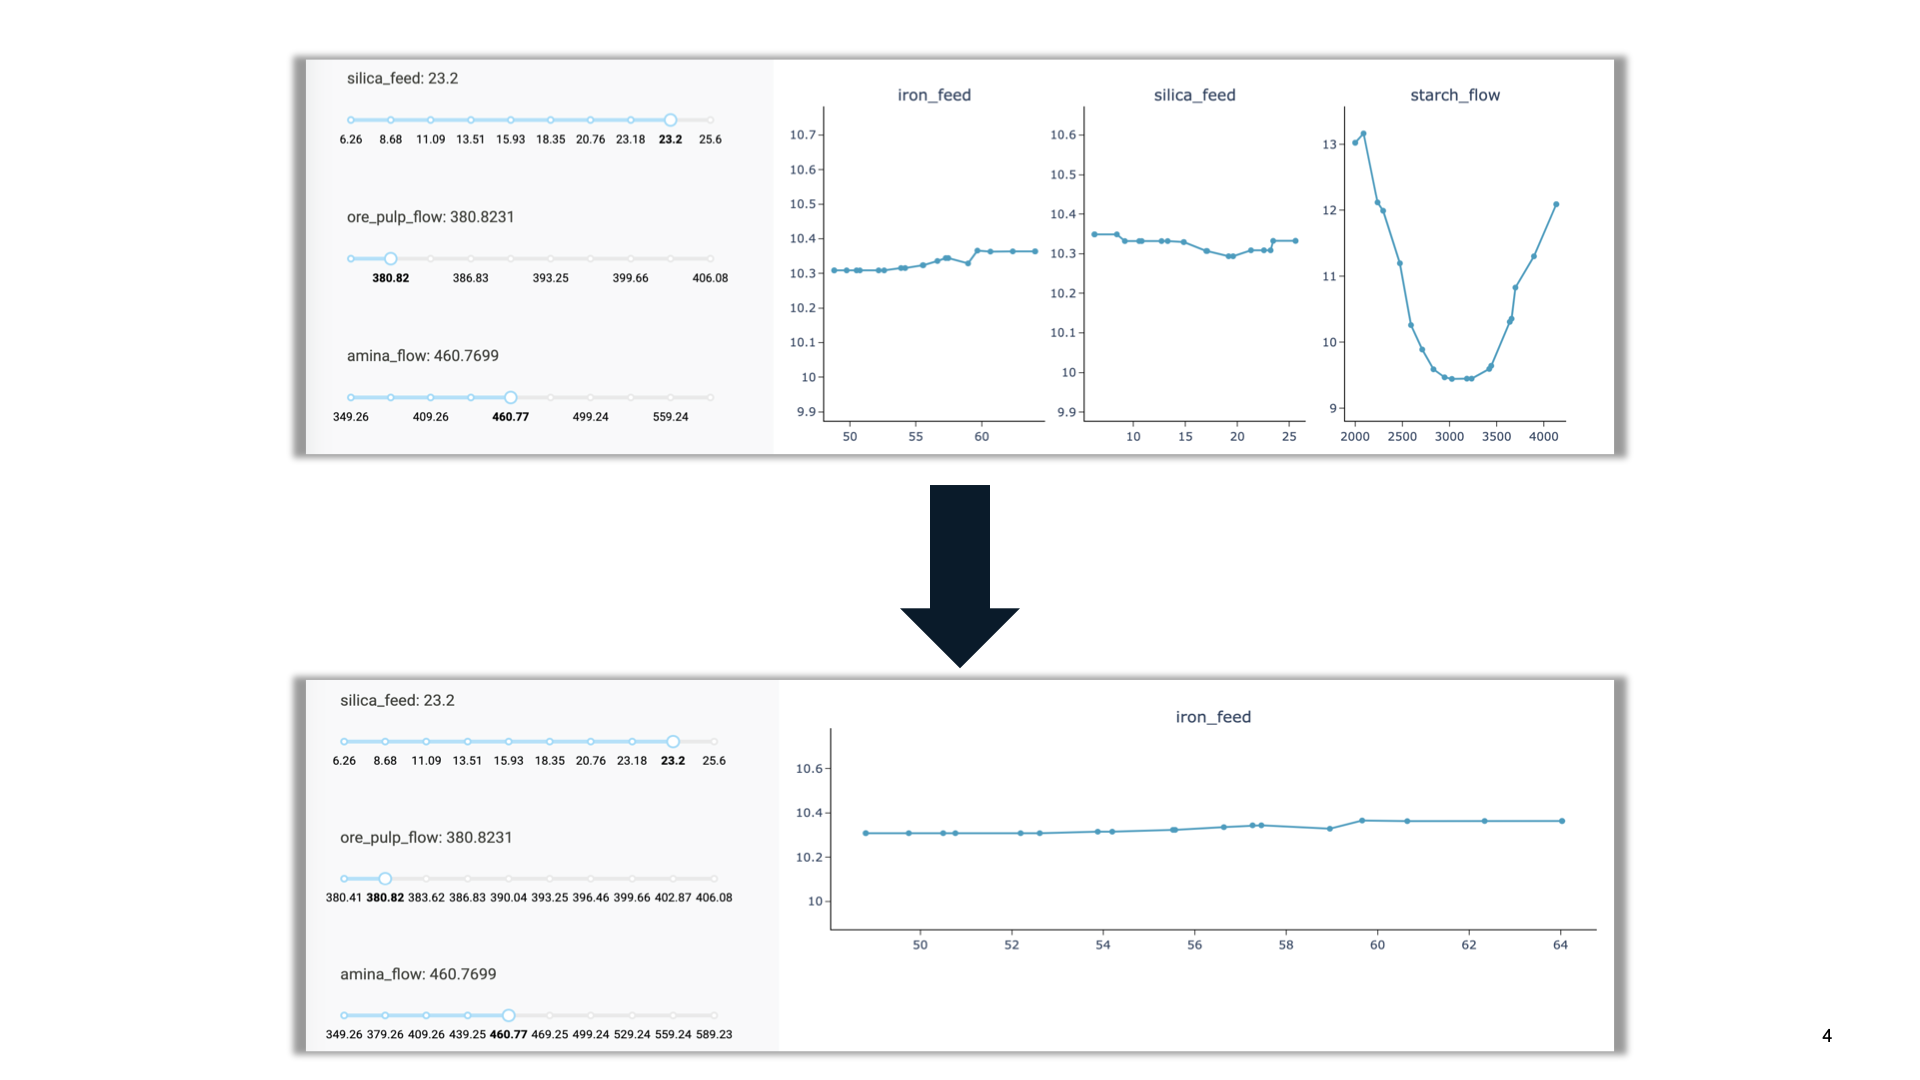

#### How to remove buttons that save current slider position?

Let's say you don't want to see the functionality for saving the layout; You can choose to disable "Save slider position" button and associated with it traces on the figure:

```python
layout_config={
    "save_slider_position": False,
},

```

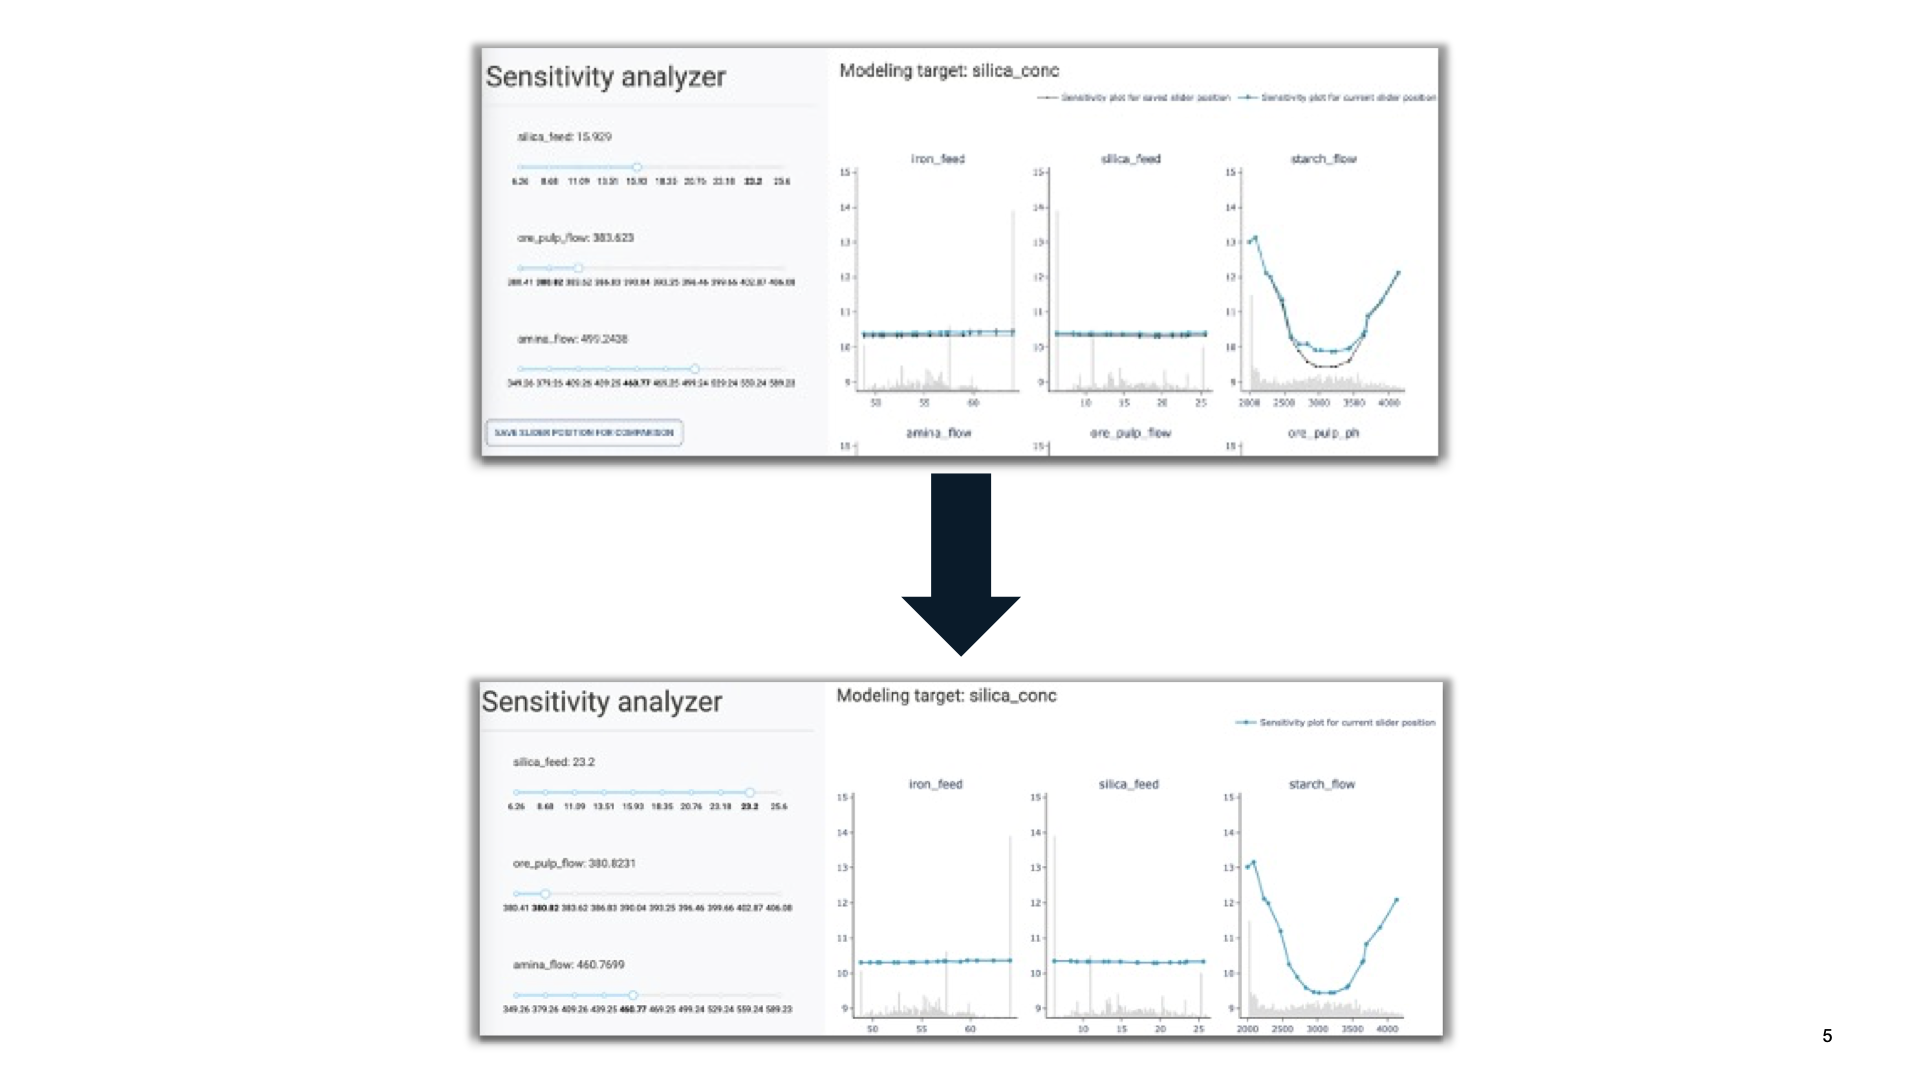

#### How to change the sidebar width on the layout?

We're providing an interface to change the sidebar width in the application. This might be relevant since there might be too much points in the sliders' grid, such that they can't fit on the screen well.

The provided parameter is used for `width` value in `style` parameter in `html.Div` block; There are multiple ways to set it up;

* "XXpx" – sets the fixed width of the sidebar; Changing the width of the screen won't affect the width of the sidebar; (default is "500px")
* "XX%" – sets the relative width of the sidebar as the share of the total screen width.


```python
layout_config={
    "sidebar_width": "25%",
},
```

#### How do I fix the overlapping sliders' marks?

We provide an option to choose how often to render marks of the sliders; This will help if the there are too many sliders' values, and they are not accurately rendered and overlap on the screen:

```python
layout_config={
    "slider_marks_show_every": {
        "amina_flow": 2,
    },
},
```

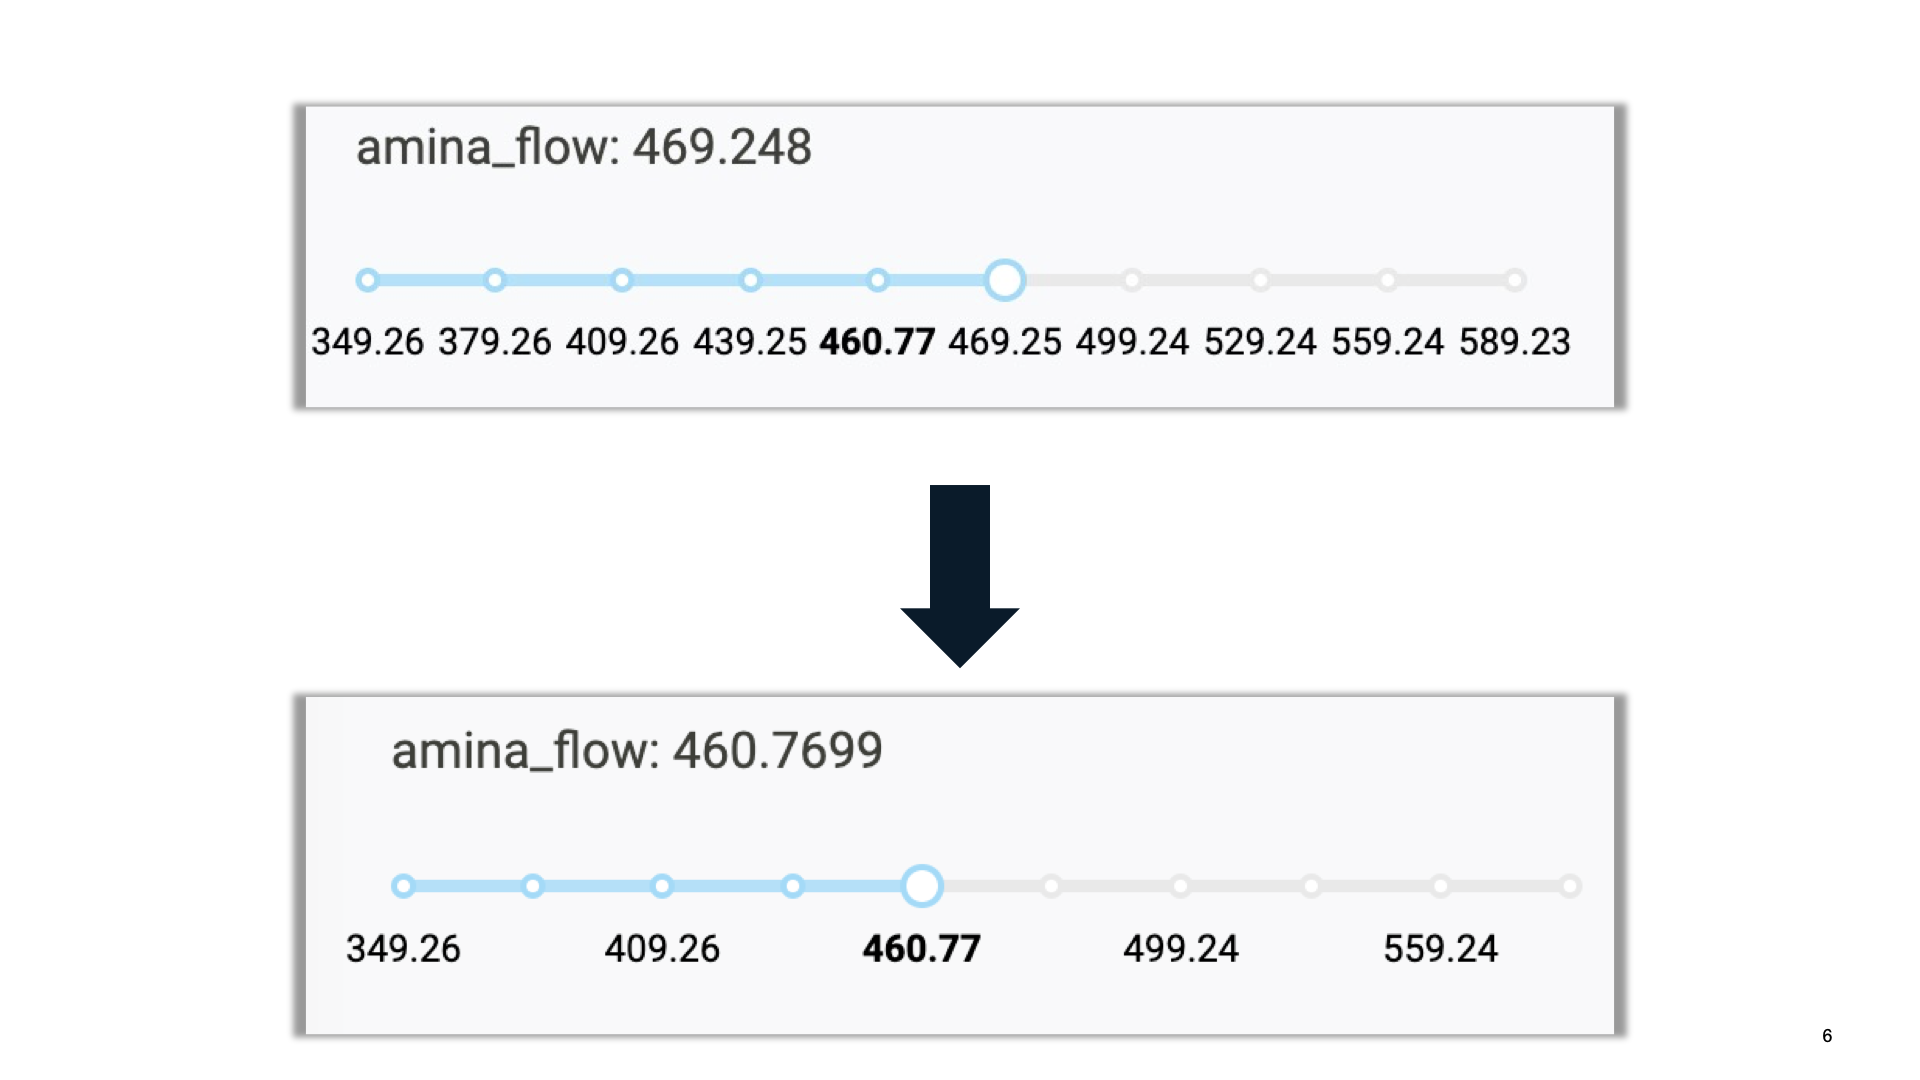

#### How do I change number of digits after decimal point in sliders' marks?

We provide an option to choose how many digits after the decimal point will be shown for the sliders' marks:

```python
layout_config={
    "slider_marks_show_every": {
        "amina_flow": 2,
    },
},
```

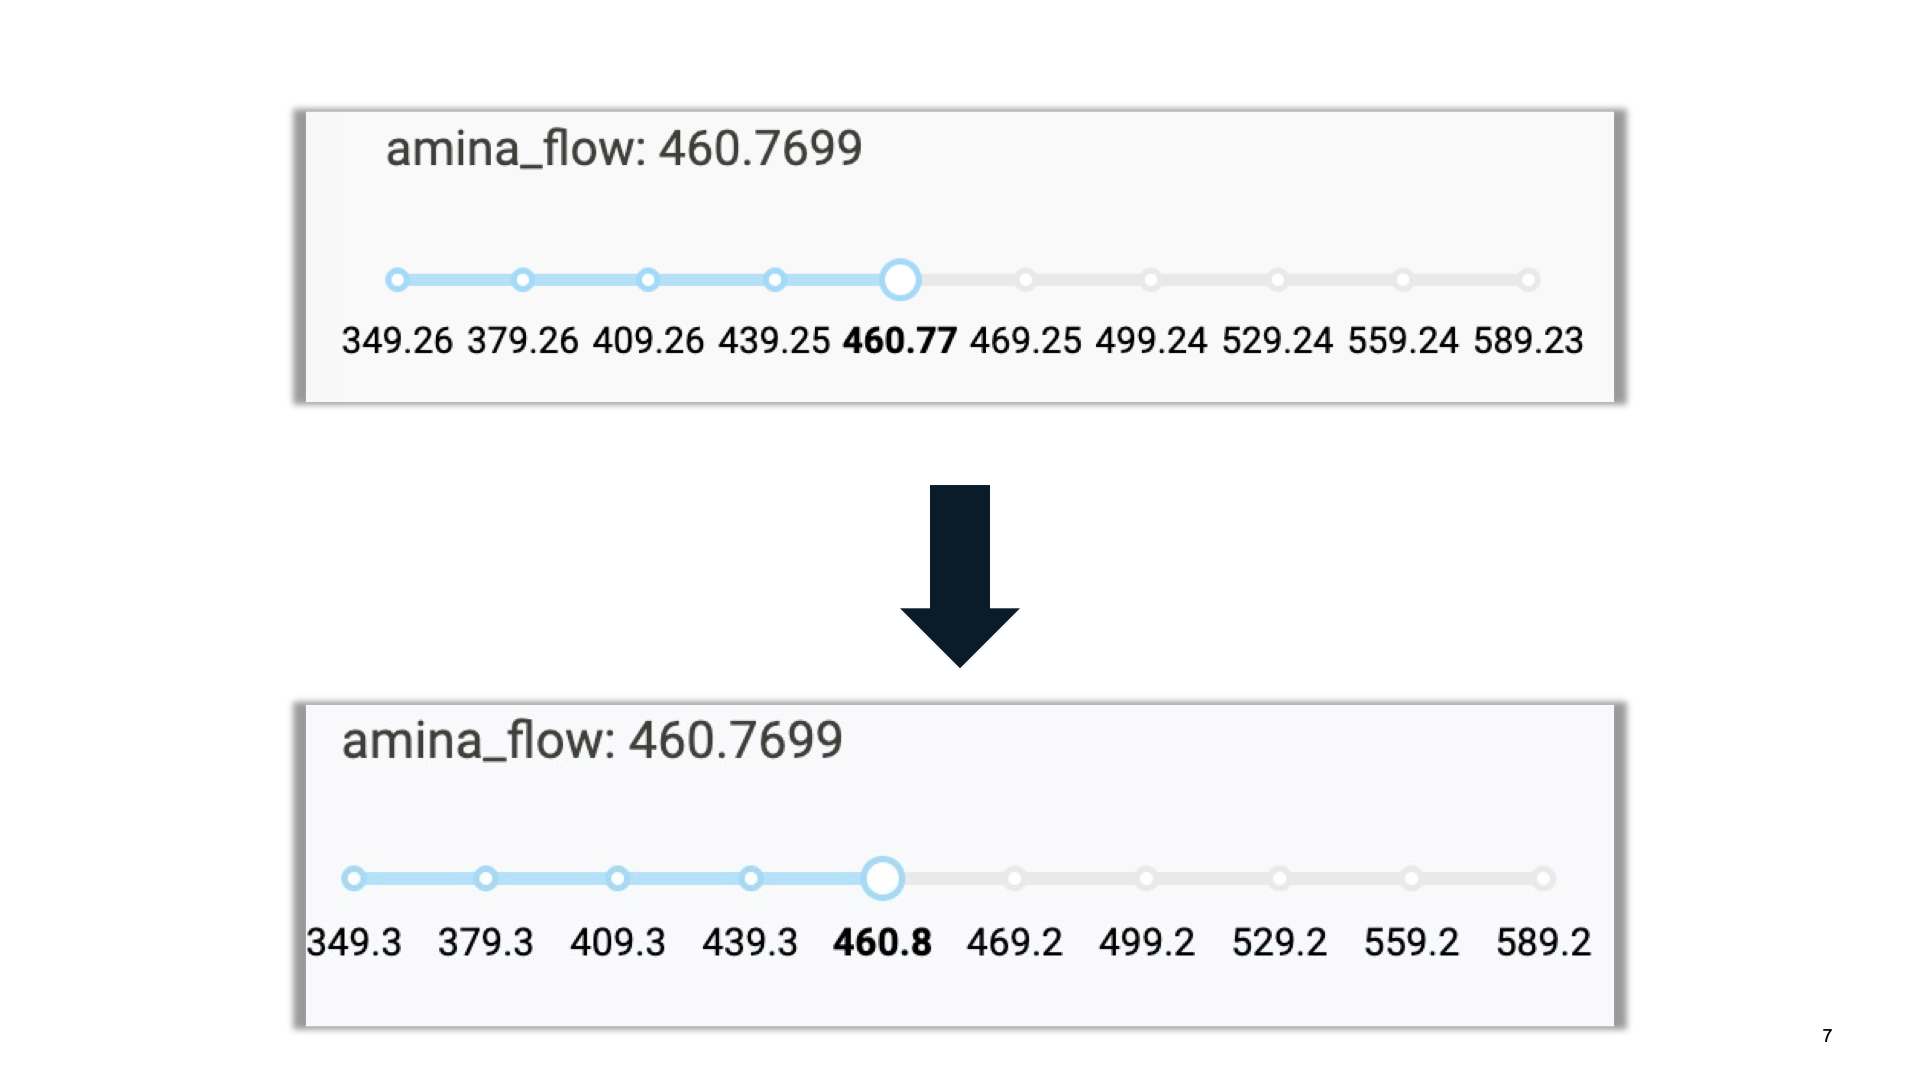

#### How do I change number of digits after decimal point in sliders' annotations?

We provide an option to choose how many digits after the decimal point will be shown for the sliders' annotations above:



```python
layout_config={
    "slider_annotation_round": {
        "amina_flow": 2,
    },
},
```

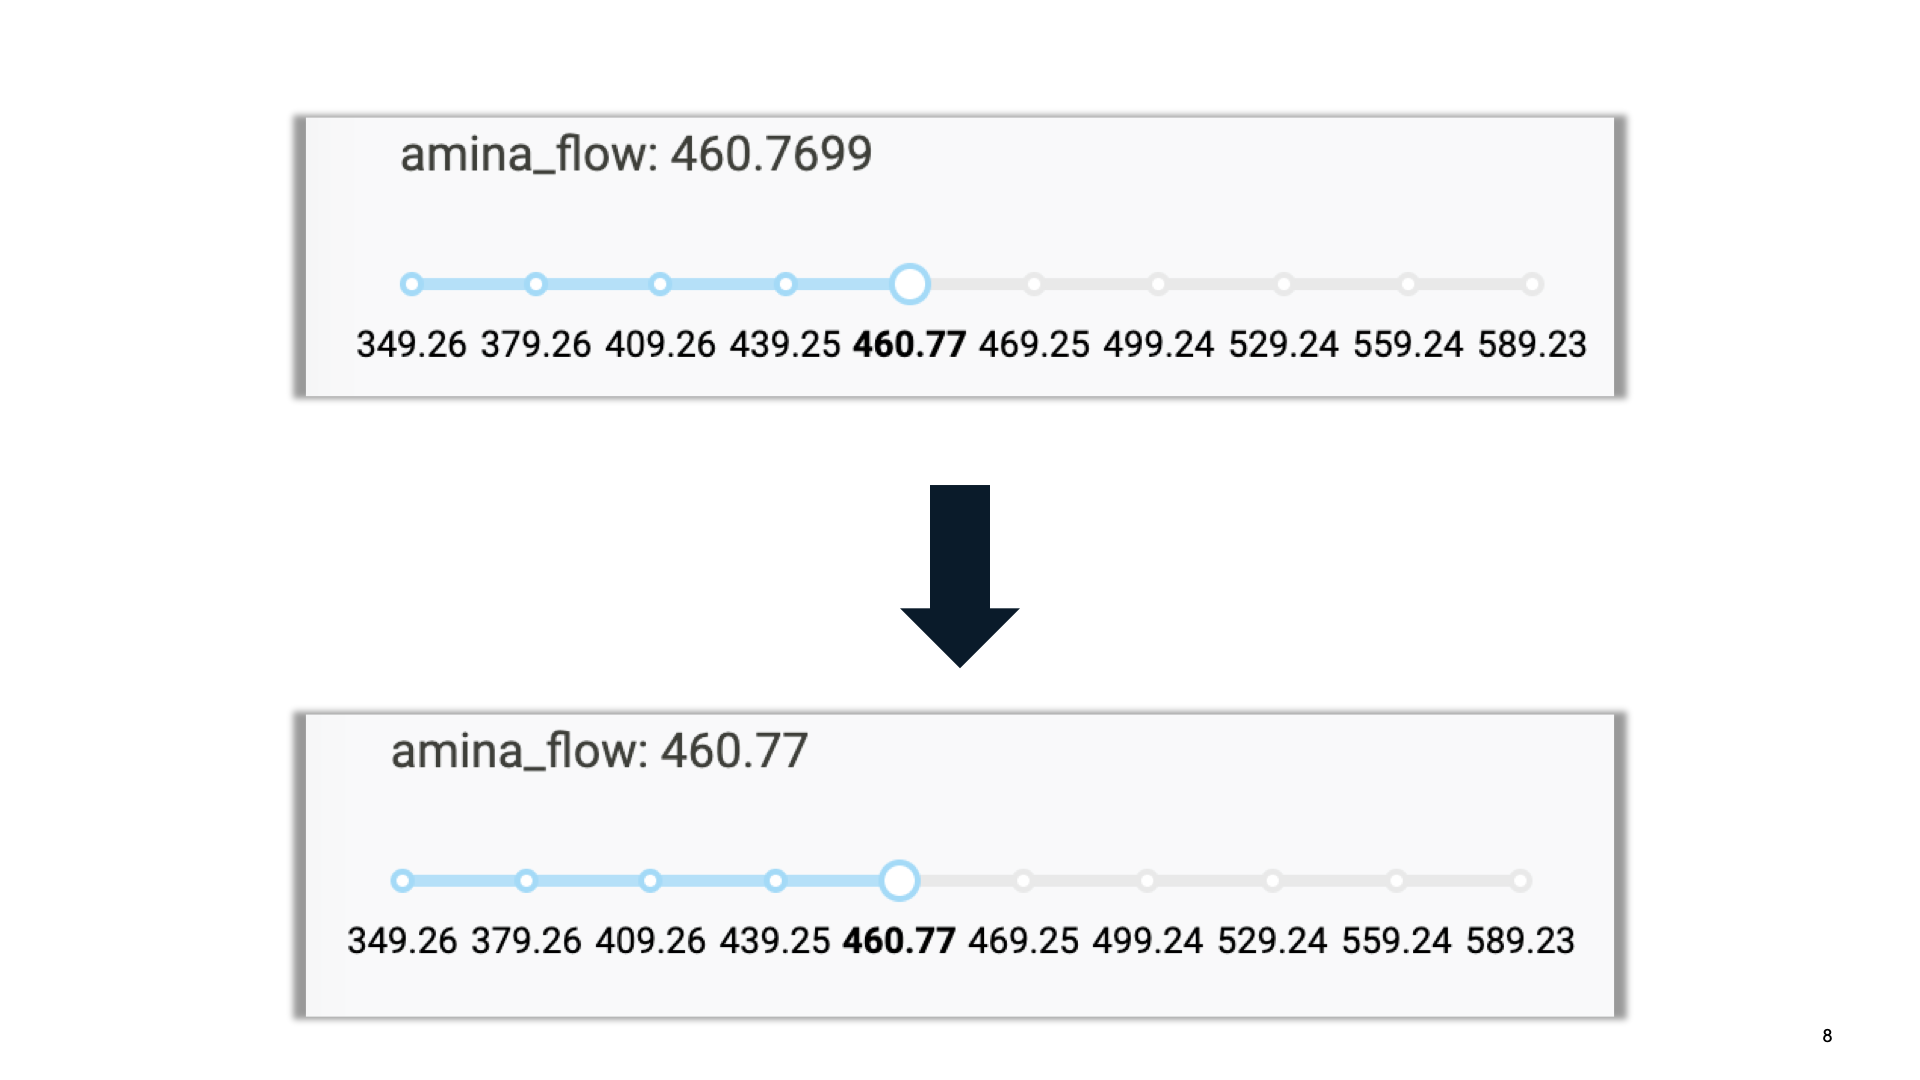

#### How do I disable informational tool tips?

We provide educational tooltips that show the instructions on how to use sensitivity analyzer right inside the application. Still, you can turn off these hints by setting:

```python
layout_config={
    "show_informational_tooltips": False
},
```

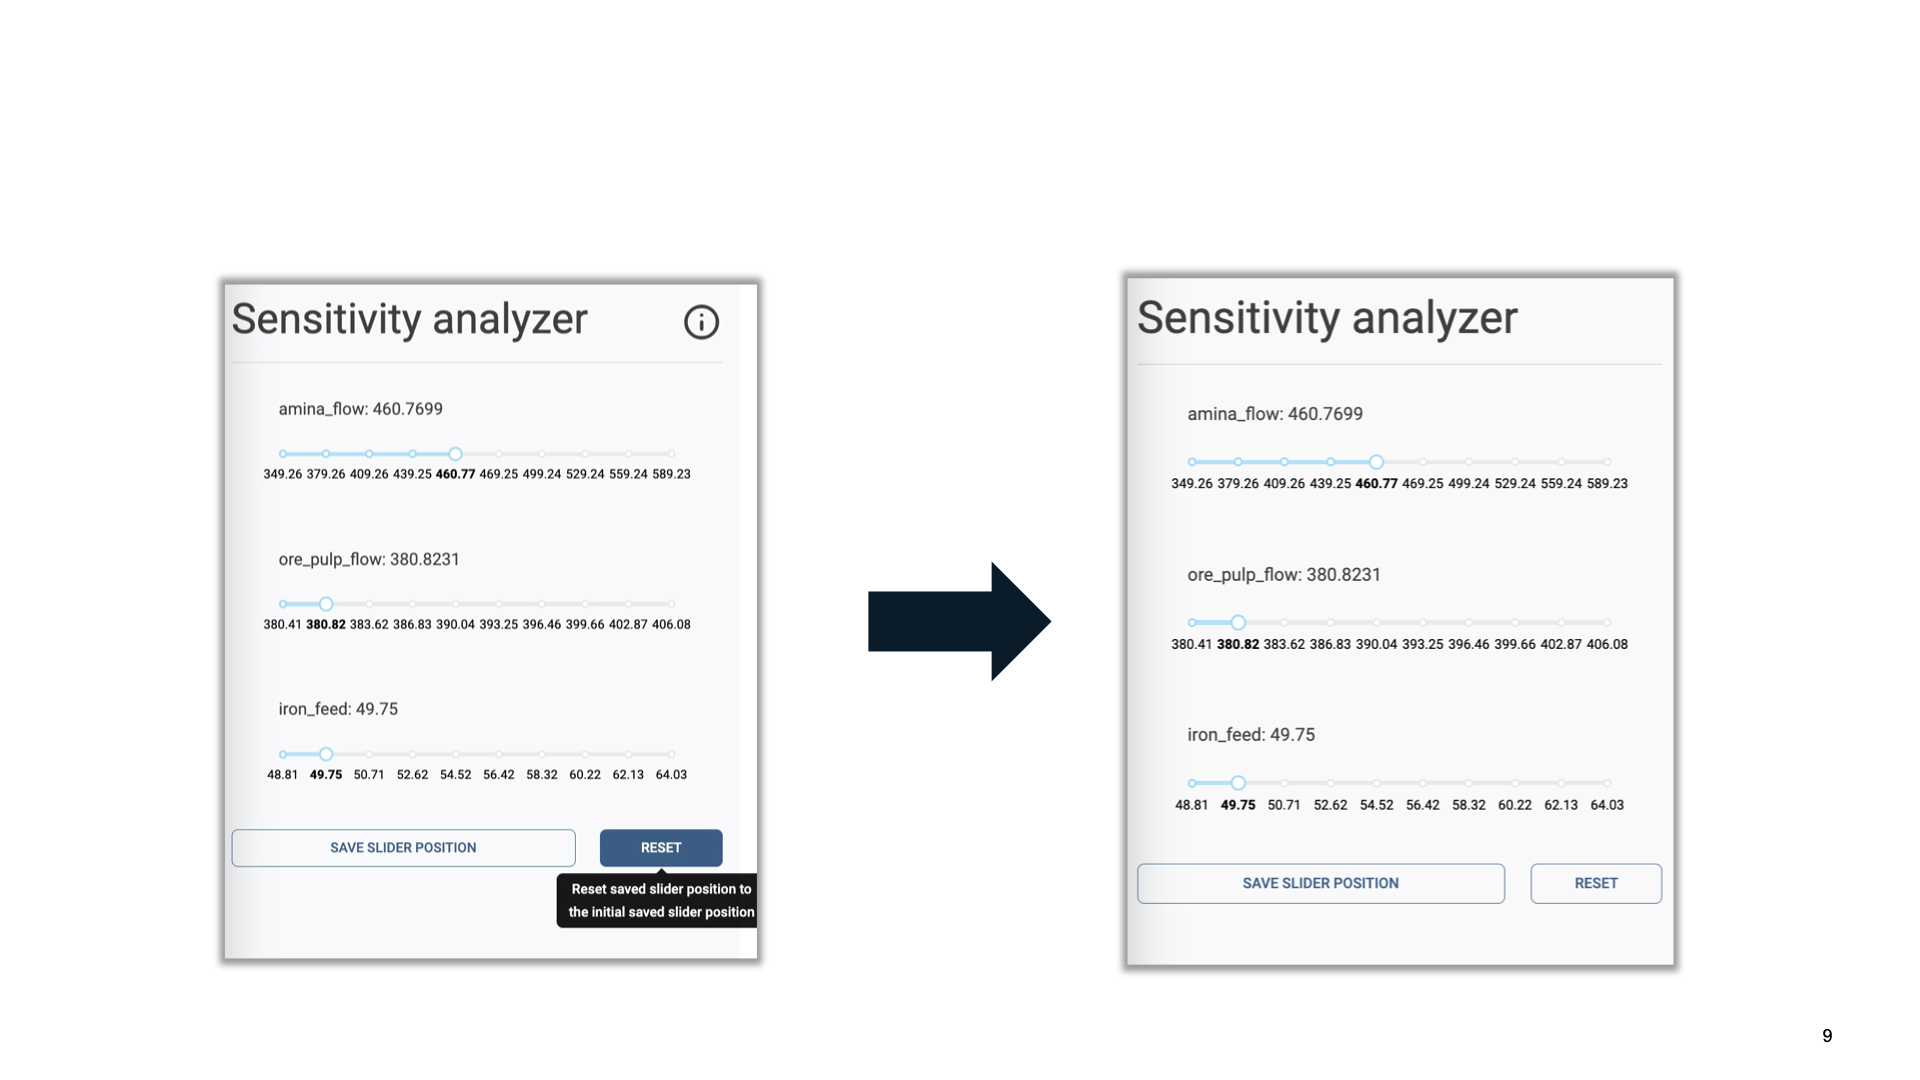

#### What if change names of features that are displayed in the application?

We allow to change names of the features that are being rendered in the application. This might be specifically helpful, when model was trained on the features with unclear names – this option allows you to switch to human-readable names that will be used in the application instead.

Simply provide a mapping from model feature into human-readable names in the following format:

```python
layout_config={
    "visualization_mapping": {
        # feature name -> human-readable name to be used in the app
        "amina_flow": "Amina Total Flow",
    },
},
```